In [1]:
import os
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

root_dir = "../"
os.sys.path.append(root_dir)

from model import Net

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_dir = os.path.join(root_dir, "data")
model_dir = os.path.join(root_dir, "pretrained_model")
explanation_dir = os.path.join(root_dir, "explanations")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = Net()
model.load_state_dict(
    torch.load(os.path.join(model_dir, "model.pt"), map_location=device)
)
model.to(device)
model.eval()
x = torch.randn(1, 3, 100, 120, device=device)
model(x)

mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)

print(f"Running shap version {shap.__version__}")

Running shap version 0.40.0


In [2]:
ref = torch.load(os.path.join(explanation_dir, "reference.pt"))
ref = ref.permute(1, 2, 0)
ref = ref.numpy()
masker = shap.maskers.Image(ref)


def f(x):
    x = torch.tensor(x).float()
    x = x.permute(0, 3, 1, 2)
    x = x.to(device)
    return model(x).detach().cpu().numpy()[..., -1]


partexp = shap.Explainer(f, masker)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


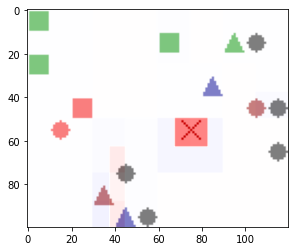

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


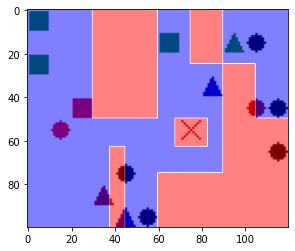

In [3]:
n = 1
true_positives = np.load(
    os.path.join(explanation_dir, "true_positive.npy"), allow_pickle=True
).item()

for i, image_path in enumerate(true_positives[n]):
    image_name = os.path.basename(image_path).split(".")[0]
    image = Image.open(os.path.join(root_dir, image_path))
    image_t = transform(image)
    image_np = image_t.permute(1, 2, 0).numpy()
    explanation = partexp(
        np.expand_dims(image_np, axis=0), max_evals=100, fixed_context=0
    )

    explanation = explanation.values[0].sum(axis=-1)
    _max = np.amax(np.abs(explanation.flatten()))
    plt.imshow(image_np)
    plt.imshow(explanation, cmap="bwr", alpha=0.5, vmin=-_max, vmax=_max)
    plt.show()
    plt.imshow(image_np)
    plt.imshow(explanation > 0, cmap="bwr", alpha=0.5)
    plt.show()
    break